# Language Identifier for tweets with CNN

In [ ]:
import csv
import re
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F

## 1. Data load

In [ ]:
# Download the files and load them into a dataframe.
from io import StringIO
import requests
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df
df_train = load_dataset(url_train_dev)
df_test = load_dataset(url_test)

In [ ]:
#label sizes
label_sizes = df_train.groupby('label').size()
# Extract labels
final_lang = df_train['label'].unique()
#label list
train_labels =df_train['label']

## 2. data preparation

### Handle class imbalance in the dataset.
- clip the number of samples in the largest classes to 3000
- remove classes with less than 5 samples

In [ ]:
df_train_freq = pd.DataFrame(label_sizes).reset_index()
df_train_freq.columns = ['label', 'frequency']
df_train_freq = df_train_freq.sort_values(by=['frequency'], ascending=True)
df_1 = df_train_freq[df_train_freq["frequency"] >= 5] 
major_lang = df_1['label'].unique()
df_train = df_train[df_train['label'].isin(major_lang)].sort_values(by=['label'])

pop_lang = df_train[df_train['label'].isin(['en', 'es', 'ja', 'und'])]
pop_lang = pop_lang.sort_values(by=['label'],ignore_index=True)
en = pop_lang.iloc[0:3000]
es = pop_lang.iloc[18508:21508]
ja = pop_lang.iloc[21508 + 5930:21508 + 5930 + 3000]
und = pop_lang.iloc[-3001:-1]

df_ = df_train.loc[df_train["label"] != 'en']
df_ = df_.loc[df_train["label"] != 'ja']
df_ = df_.loc[df_train["label"] != 'es']
df_ = df_.loc[df_train["label"] != 'und']
df_train_final = pd.concat([df_, en, es, ja, und])

### Tokenization

Split the tweets into characters

In [ ]:
vocab = set()
for sent in df_train.tweet:
    for char in sent:
        vocab.add(char)

print("Total characters:", len(vocab))

Total characters: 5701


In [ ]:
# Map each item in the vocabulary to an index:
token_to_idx = {'<pad>': 0, '<unk>': 1}
for idx, token in enumerate(vocab, start=2):
    token_to_idx[token] = idx
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

In [ ]:
# Define encoding and decoding functions:
def encode_sent(sent):
    # sentence to token indices
    return [token_to_idx.get(token, token_to_idx['<unk>']) for token in sent]

def decode_sent(indices):
    # token indices to sentence
    return [idx_to_token[idx] for idx in indices]

def pad_truncate_sent(indices, max_length):
    # create a feature vector of max_length
    if len(indices) >= max_length:
        return indices[:max_length]
    return indices + [token_to_idx['<pad>']] * (max_length - len(indices))


### label encoding
assigning indexes to labels


In [ ]:
# list of languages + unknown (e.g. not in the train set)
lang_list = final_lang.tolist() + ["<unk>"]

# language label to index
label_to_idx = {k: v for v, k in enumerate(lang_list)}

# index to language lable
idx_to_label = {v: k for k, v in label_to_idx.items()}

def encode_label(label):
    return label_to_idx.get(label, label_to_idx["<unk>"])

def decode_label(idx):
    return idx_to_label.get(idx, "<unk>")

### data (tweets) encoding

In [ ]:
def encode_dataset(data, max_len):
    encoded_data = []  # list of tuples (token-indices, label-idx)
    label_idx_list = [] #
    for index, row in data.iterrows():
        i = row.to_dict()
        token_indices = pad_truncate_sent(encode_sent(i["tweet"]), max_len)
        label_idx = encode_label(i["label"])
        encoded_data.append((token_indices, label_idx))
        label_idx_list.append(label_idx)
    return encoded_data , label_idx_list

In [ ]:
max_len = 50
encoded_trainset, label_idx_list = encode_dataset(df_train, max_len=max_len) # label_idx_list

### build dataset wrapper

In [ ]:
from torch.utils.data.dataset import Dataset
class TweetDataset(Dataset):

    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __getitem__(self, idx):
        token_idxs, label = self.encoded_data[idx]
        return torch.LongTensor(token_idxs), label
    
    def __len__(self):
        return len(self.encoded_data)

In [ ]:
trainset = TweetDataset(encoded_trainset)

## 3. Split train/val set

Create train and validation sets. 


In [ ]:
# Split train/val set - as identical as the propotion using in model-based methods
rate = 0.75
n = len(trainset.encoded_data)
train_len = int(n * rate)
devset, valset = random_split(trainset, [train_len, n - train_len])
print("Development set:", len(devset))
print("Validation set:", len(valset))

Development set: 39478
Validation set: 13160


##4. Configure the GPU

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
cuda = torch.device('cuda')
device = cuda if torch.cuda.is_available() else 'cpu'

1
Tesla P100-PCIE-16GB


In [ ]:
vocab_size = len(idx_to_token)
num_classes = len(label_to_idx)
print("Vocab size:", vocab_size)
print("Num classes:", num_classes)

Vocab size: 5703
Num classes: 70


## 5. Define the Convolutional Neural Network

In [ ]:
from torch import nn
import math


class LanguageIdentification(nn.Module):

    def __init__(self, vocab_size, embedding_size, max_len, num_classes, kernel_size, out_channels, stride, padding, dropout_rate, max_pool_size, cov2_kernel_size):
        super(LanguageIdentification, self).__init__()

        self.out_channels = out_channels
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.in_channels = 1
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.max_pool_size = max_pool_size
        self.cov2_kernel_size = cov2_kernel_size
        
        conv_1_out_shape_x = math.floor(((max_len + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0]) + 1)
        conv_1_out_shape_y = math.floor(((embedding_size + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1]) + 1)
        pool_1_out_shape_x = math.floor(((conv_1_out_shape_x + 2 * padding[0] - (max_pool_size[0] - 1) - 1) / stride[0]) + 1)
        pool_1_out_shape_y = math.floor(((conv_1_out_shape_y + 2 * padding[1] - (max_pool_size[1] - 1) - 1) / stride[1]) + 1)
        
        conv_2_out_shape_x = math.floor((((pool_1_out_shape_x + 2 * padding[0] - (cov2_kernel_size[0] - 1)) - 1) / stride[0]) + 1)
        conv_2_out_shape_y = math.floor((((pool_1_out_shape_y + 2 * padding[1] - (cov2_kernel_size[1] - 1)) - 1) / stride[1]) + 1)
        pool_2_out_shape_x = math.floor(((conv_2_out_shape_x + 2 * padding[0] - (max_pool_size[0] - 1) - 1) / stride[0]) + 1)
        pool_2_out_shape_y = math.floor(((conv_2_out_shape_y + 2 * padding[1] - (max_pool_size[1] - 1) - 1) / stride[1]) + 1)
        
        self.num_final_features = self.out_channels * pool_2_out_shape_x * pool_2_out_shape_y
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.conv2d = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.max_pool2d = nn.MaxPool2d(kernel_size=max_pool_size, stride=self.stride, padding=self.padding)
        self.conv2d_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=self.cov2_kernel_size, stride=self.stride, padding=self.padding)
        self.max_pool2d_2 = nn.MaxPool2d(kernel_size=max_pool_size, stride=self.stride, padding=self.padding)
        self.linear = nn.Linear(self.num_final_features, self.num_classes)
    

    def forward(self, inputs):
        batchsize = inputs.size()[0]

        # (batch-size, max-len, emb-size)
        embeddings = self.embeddings(inputs)

        # reduce dimensionality of the embeddings
        embs_unsq = torch.unsqueeze(embeddings, 1)
        
        # 1st convolution and relu
        conv_out = nn.functional.relu(self.conv2d(embs_unsq))

        # 1st max pool
        pool_out = self.max_pool2d(conv_out)

        # 2nd max convolution and relu
        conv_2_out = nn.functional.relu(self.conv2d_2(pool_out))

        # 2nd max pooling
        pool_out_2 = self.max_pool2d_2(conv_2_out)

        # reshape 2d into a vector
        pool_out_2_reshaped = pool_out_2.view(-1, self.num_final_features)

        # dense layer and softmax
        lin_out = self.linear(F.dropout(pool_out_2_reshaped, self.dropout_rate))
        log_probs = nn.functional.log_softmax(lin_out, dim=1)
        return log_probs

## 6. Define the training function

In [ ]:
#assigning weights for Negative Log-Likelihood function
import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels) #calculating weight
#w_unk = class_weights[0:1] #add the weight of unk label by the weight of the fist label in the array (the label with high freq)
#w_unk = 3*class_weights[0:1]
w_unk = 100*class_weights[0:1]
class_weights_ = np.append(class_weights, w_unk) #now.. len = 70 = 69 + 1 = number_class + <unk> 
weights= torch.tensor(class_weights_,dtype=torch.float)
print("Weights of loss function:", weights)
loss_func = nn.NLLLoss(weight=weights)

Weights of loss function: tensor([3.4716e-01, 6.3617e+01, 7.6341e+02, 3.8170e+02, 9.5426e+01, 1.9085e+02,
        3.4700e+01, 1.9085e+02, 7.6341e+02, 1.0906e+02, 4.4644e+00, 7.6341e+02,
        2.7264e+01, 4.1247e-02, 1.2874e-01, 3.8170e+02, 4.2411e+01, 5.0894e+01,
        8.0698e-01, 2.5447e+02, 7.6341e+02, 2.8274e+01, 4.7713e+01, 5.0894e+01,
        1.5268e+02, 3.8170e+02, 5.0894e+01, 3.8170e+02, 2.5396e-01, 7.6341e+02,
        2.2519e+00, 7.3256e-02, 7.6341e+02, 7.6341e+01, 3.8170e+02, 1.6668e+00,
        7.6341e+02, 6.4152e+00, 1.5268e+02, 4.1945e+00, 6.9401e+01, 8.2087e+00,
        7.6341e+02, 7.6341e+02, 2.6526e-01, 6.3617e+01, 7.8058e-01, 7.6341e+02,
        3.8170e+02, 8.4823e+01, 3.4700e+01, 7.6341e+01, 1.4137e+01, 1.2723e+02,
        8.4823e+01, 7.6341e+02, 1.6524e+00, 2.3856e+00, 7.6341e+02, 1.1411e+00,
        4.7713e+01, 1.6826e-01, 1.0906e+02, 6.3617e+01, 4.7713e+01, 7.6341e+02,
        7.6341e+02, 3.0536e+01, 7.6341e+01, 3.4716e+01])


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

def get_data(config, data):
  data_loaded = DataLoader(
    data,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True)
  return data_loaded

def get_loss(model, data_loader):
    losses = []
    model.eval()
    with torch.no_grad():
        for token_ids, label_ids in data_loader:
            token_ids = token_ids.to(device)
            label_ids = label_ids.to(device)
            y_pred = model(token_ids)
            loss = loss_func(y_pred, label_ids)
            loss_batch = loss.item()
            losses.append(loss_batch)
    return np.mean(losses)

loss_func = nn.NLLLoss()

def train_model(model, optimizer, scheduler, loss_func, device, num_epochs, dev_loader, val_loader):
    dev_loss = []
    val_loss = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        losses = []
        batch_num = 0
        for token_ids, label_ids in dev_loader:
            batch_num += 1
            token_ids = token_ids.to(device)
            label_ids = label_ids.to(device)
            optimizer.zero_grad()
            y_pred = model(token_ids)
            loss = loss_func(y_pred, label_ids)
            loss_batch = loss.item()
            loss.backward()
            optimizer.step()
            losses.append(loss_batch)
        avg_loss = np.mean(losses[-10:])
        print(f'Epoch {epoch}/{num_epochs}, avg. loss: {avg_loss:.4f}, lr: {scheduler.get_last_lr()[0]}')
        scheduler.step()

        # evaluate the model after each epoch
        dev_loss.append(get_loss(model, dev_loader))
        val_loss.append(get_loss(model, val_loader))
    return dev_loss, val_loss

def train_config(config, devset, valset):
    dev_loader = get_data(config, devset)
    val_loader = get_data(config, valset)
    num_epochs = config["num_epochs"]
    model = LanguageIdentification(
        vocab_size,
        config["embedding_size"],
        max_len,
        num_classes,
        config["kernel_size"],
        config["out_channels"],
        config["stride"],
        config["padding"],
        config["dropout"],
        config["max_pool_size"],
        config["cov2_kernel_size"]
    ) 
    model.to(device)
    # training parameters
    #loss_func = nn.NLLLoss(weight=weights).to(device)
    loss_func = nn.NLLLoss()
    lr = config["lr"]
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    dev_loss, val_loss = train_model(
        model,
        optimizer, 
        scheduler,
        loss_func,
        device,
        num_epochs,
        dev_loader,
        val_loader)

    plt.figure()
    plt.title("Loss")
    plt.plot(list(range(num_epochs)), dev_loss, label="development")
    plt.plot(list(range(num_epochs)), val_loss, label="validation")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return model


## 4. Define the evaluation function

In [ ]:
def evaluate_model(config, model, data):
    data_loader = get_data (config,data)
    predicted = []
    gold = []
    model.eval()
    with torch.no_grad():
        for token_ids, label_ids in data_loader:
            token_ids = token_ids.to(device)
            label_ids = label_ids.to(device)
            log_probs = model(token_ids)
            y_pred = log_probs.argmax(dim=1)
            predicted.extend([i.item() for i in y_pred])
            gold.extend(label_ids.cpu().numpy())
    accuracy = accuracy_score(gold, predicted)
    f1_macro = f1_score(gold, predicted, average='macro')
    return accuracy, f1_macro

## 5. Train the networks

Epoch 1/50, avg. loss: 3.3028, lr: 0.0001
Epoch 2/50, avg. loss: 3.1131, lr: 0.0001
Epoch 3/50, avg. loss: 3.2563, lr: 0.0001
Epoch 4/50, avg. loss: 2.4442, lr: 0.0001
Epoch 5/50, avg. loss: 2.4076, lr: 0.0001
Epoch 6/50, avg. loss: 3.1609, lr: 0.0001
Epoch 7/50, avg. loss: 2.3254, lr: 0.0001
Epoch 8/50, avg. loss: 1.9629, lr: 0.0001
Epoch 9/50, avg. loss: 3.0056, lr: 0.0001
Epoch 10/50, avg. loss: 2.2981, lr: 0.0001
Epoch 11/50, avg. loss: 2.4791, lr: 5e-05
Epoch 12/50, avg. loss: 1.6631, lr: 5e-05
Epoch 13/50, avg. loss: 1.7696, lr: 5e-05
Epoch 14/50, avg. loss: 1.8213, lr: 5e-05
Epoch 15/50, avg. loss: 1.8869, lr: 5e-05
Epoch 16/50, avg. loss: 2.5549, lr: 5e-05
Epoch 17/50, avg. loss: 2.1614, lr: 5e-05
Epoch 18/50, avg. loss: 1.8740, lr: 5e-05
Epoch 19/50, avg. loss: 1.8084, lr: 5e-05
Epoch 20/50, avg. loss: 1.9909, lr: 5e-05
Epoch 21/50, avg. loss: 1.9148, lr: 2.5e-05
Epoch 22/50, avg. loss: 1.6552, lr: 2.5e-05
Epoch 23/50, avg. loss: 1.6659, lr: 2.5e-05
Epoch 24/50, avg. loss: 1.4

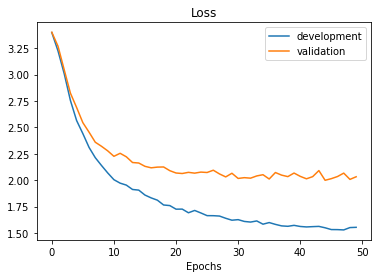

Development (acc, f1):  (0.5698246147607462, 0.3053145879370864)
Validation (acc, f1):  (0.5645529197080292, 0.19016719726397013)


In [ ]:
#@tittle: model 1
#optimizer: Adam #loss_weights: yes, w_unk = 3*w_ar
config1 = {
    "embedding_size": 32,
    "max_pool_size": (2, 2),
    "kernel_size": (6, 6),
    "out_channels": 16,
    "stride": (2, 2),
    "padding": (1, 1),
    "dropout": 0.1,
    "lr": 0.0001,
    "num_epochs": 50,
    "cov2_kernel_size": (6, 6),
    "batch_size": 32}
model1 = train_config(config1, devset, valset)
print("Development (acc, f1): ", evaluate_model(config1, model1, devset))
print("Validation (acc, f1): ", evaluate_model(config1, model1, valset))

``The loss of the model1 is too high.. we have to reduce the drop out rate and might be change the loss function.
By increasing the weight of unknow label, we hope the model will be improved.``

Epoch 1/15, avg. loss: 2.8916, lr: 0.001
Epoch 2/15, avg. loss: 3.1070, lr: 0.001
Epoch 3/15, avg. loss: 3.1188, lr: 0.001
Epoch 4/15, avg. loss: 3.1223, lr: 0.001
Epoch 5/15, avg. loss: 2.4948, lr: 0.001
Epoch 6/15, avg. loss: 2.9394, lr: 0.001
Epoch 7/15, avg. loss: 2.9030, lr: 0.001
Epoch 8/15, avg. loss: 2.6036, lr: 0.001
Epoch 9/15, avg. loss: 2.7821, lr: 0.001
Epoch 10/15, avg. loss: 3.0167, lr: 0.001
Epoch 11/15, avg. loss: 3.4253, lr: 0.0005
Epoch 12/15, avg. loss: 2.8356, lr: 0.0005
Epoch 13/15, avg. loss: 2.8555, lr: 0.0005
Epoch 14/15, avg. loss: 2.8092, lr: 0.0005
Epoch 15/15, avg. loss: 2.8666, lr: 0.0005


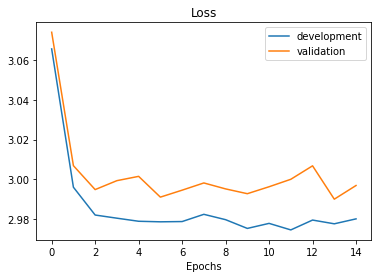

Development (acc, f1):  (0.35300972841507905, 0.011343783225789644)
Validation (acc, f1):  (0.3473404255319149, 0.01171804902558949)


In [ ]:
#@tittle: model 2
#optimizer: Adam  #loss_weights: yes, w_unk = 100*w_ar
config2 = {
    "embedding_size": 100,
    "max_pool_size": (2, 2),
    "kernel_size": (3, 3),
    "out_channels": 16,
    "stride": (1, 1),
    "padding": (1, 1),
    "dropout": 0.1,
    "lr": 0.001,
    "num_epochs": 15,
    "cov2_kernel_size": (6, 6),
    "batch_size":8}
model2 = train_config(config2, devset, valset)
print("Development (acc, f1): ", evaluate_model(config2,model2, devset))
print("Validation (acc, f1): ", evaluate_model(config2,model2, valset))


Epoch 1/15, avg. loss: 0.9291, lr: 0.001
Epoch 2/15, avg. loss: 0.7332, lr: 0.001
Epoch 3/15, avg. loss: 0.5284, lr: 0.001
Epoch 4/15, avg. loss: 0.6888, lr: 0.001
Epoch 5/15, avg. loss: 0.5734, lr: 0.001
Epoch 6/15, avg. loss: 0.4745, lr: 0.001
Epoch 7/15, avg. loss: 0.5104, lr: 0.001
Epoch 8/15, avg. loss: 0.5111, lr: 0.001
Epoch 9/15, avg. loss: 0.5152, lr: 0.001
Epoch 10/15, avg. loss: 0.4687, lr: 0.001
Epoch 11/15, avg. loss: 0.4274, lr: 0.0005
Epoch 12/15, avg. loss: 0.4682, lr: 0.0005
Epoch 13/15, avg. loss: 0.4098, lr: 0.0005
Epoch 14/15, avg. loss: 0.3952, lr: 0.0005
Epoch 15/15, avg. loss: 0.5222, lr: 0.0005


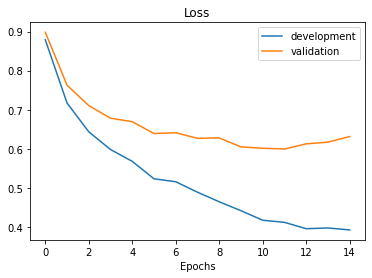

Development (acc, f1):  (0.8754055150040552, 0.571687060351019)
Validation (acc, f1):  (0.8281630170316302, 0.2908136713255059)


In [ ]:
#@title: model 3
#optimizer: Adam  #no loss_weights
config3 = {
    "embedding_size": 32,
    "max_pool_size": (2, 2),
    "kernel_size": (6, 6),
    "out_channels": 16,
    "stride": (2, 2),
    "padding": (1, 1),
    "dropout": 0.1,
    "lr": 0.001,
    "num_epochs": 15,
    "cov2_kernel_size": (6, 6),
    "batch_size": 32}
model3 = train_config(config3, devset, valset)
print("Development (acc, f1): ", evaluate_model(config3, model3, devset))
print("Validation (acc, f1): ", evaluate_model(config3, model3, valset))

Epoch 1/20, avg. loss: 0.8758, lr: 0.001
Epoch 2/20, avg. loss: 0.7502, lr: 0.001
Epoch 3/20, avg. loss: 0.6648, lr: 0.001
Epoch 4/20, avg. loss: 0.5910, lr: 0.001
Epoch 5/20, avg. loss: 0.4910, lr: 0.001
Epoch 6/20, avg. loss: 0.6277, lr: 0.001
Epoch 7/20, avg. loss: 0.5591, lr: 0.001
Epoch 8/20, avg. loss: 0.6147, lr: 0.001
Epoch 9/20, avg. loss: 0.5367, lr: 0.001
Epoch 10/20, avg. loss: 0.5576, lr: 0.001
Epoch 11/20, avg. loss: 0.2821, lr: 0.0005
Epoch 12/20, avg. loss: 0.3177, lr: 0.0005
Epoch 13/20, avg. loss: 0.4004, lr: 0.0005
Epoch 14/20, avg. loss: 0.5459, lr: 0.0005
Epoch 15/20, avg. loss: 0.6807, lr: 0.0005
Epoch 16/20, avg. loss: 0.3321, lr: 0.0005
Epoch 17/20, avg. loss: 0.4690, lr: 0.0005
Epoch 18/20, avg. loss: 0.4562, lr: 0.0005
Epoch 19/20, avg. loss: 0.3449, lr: 0.0005
Epoch 20/20, avg. loss: 0.4601, lr: 0.0005


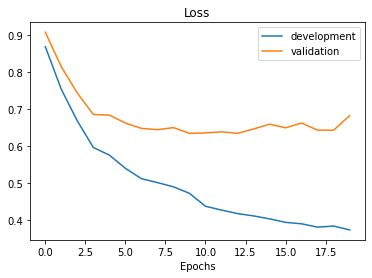

Development (acc, f1):  (0.8796868666396432, 0.6118029268729426)
Validation (acc, f1):  (0.8384498480243161, 0.2669434208951756)


In [ ]:
#@title: model 4
#optimizer: Adam #loss_weights: yes
config43 = {
    "embedding_size": 32,
    "max_pool_size": (2, 2),
    "kernel_size": (3, 3),
    "out_channels": 16,
    "stride": (2, 2),
    "padding": (1, 1),
    "dropout": 0.3,
    "lr": 0.001,
    "num_epochs": 20,
    "cov2_kernel_size": (5, 5),
    "batch_size":8}
model43 = train_config(config43, devset, valset)
print("Development (acc, f1): ", evaluate_model(config43,model43, devset))
print("Validation (acc, f1): ", evaluate_model(config43,model43, valset))

Epoch 1/17, avg. loss: 1.1919, lr: 0.001
Epoch 2/17, avg. loss: 0.8336, lr: 0.001
Epoch 3/17, avg. loss: 0.6635, lr: 0.001
Epoch 4/17, avg. loss: 0.6254, lr: 0.001
Epoch 5/17, avg. loss: 0.8667, lr: 0.001
Epoch 6/17, avg. loss: 0.3806, lr: 0.001
Epoch 7/17, avg. loss: 0.3287, lr: 0.001
Epoch 8/17, avg. loss: 0.4361, lr: 0.001
Epoch 9/17, avg. loss: 0.2718, lr: 0.001
Epoch 10/17, avg. loss: 0.4454, lr: 0.001
Epoch 11/17, avg. loss: 0.1783, lr: 0.0005
Epoch 12/17, avg. loss: 0.1302, lr: 0.0005
Epoch 13/17, avg. loss: 0.1810, lr: 0.0005
Epoch 14/17, avg. loss: 0.1826, lr: 0.0005
Epoch 15/17, avg. loss: 0.0741, lr: 0.0005
Epoch 16/17, avg. loss: 0.1426, lr: 0.0005
Epoch 17/17, avg. loss: 0.2258, lr: 0.0005


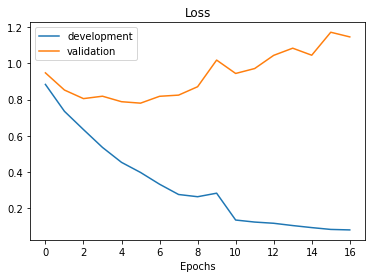

Development (acc, f1):  (0.9713721118767734, 0.9882845876168667)
Validation (acc, f1):  (0.796580547112462, 0.24383930551433125)


In [ ]:
#@title: model 5
#optimizer: SGD #no weight_loss
config5 = {
    "embedding_size": 32,
    "max_pool_size": (2, 2),
    "kernel_size": (6, 6),
    "out_channels": 16,
    "stride": (1, 1),
    "padding": (1, 1),
    "dropout": 0.2,
    "lr": 0.001,
    "num_epochs": 17,
    "cov2_kernel_size": (6, 6),
    "batch_size": 8
}
model5 = train_config(config5, devset, valset)
print("Development (acc, f1): ", evaluate_model(config5,model5, devset))
print("Validation (acc, f1): ", evaluate_model(config5,model5, valset))

Epoch 1/20, avg. loss: 1.4898, lr: 0.001
Epoch 2/20, avg. loss: 0.7858, lr: 0.001
Epoch 3/20, avg. loss: 0.8617, lr: 0.001
Epoch 4/20, avg. loss: 1.0818, lr: 0.001
Epoch 5/20, avg. loss: 0.8673, lr: 0.001
Epoch 6/20, avg. loss: 0.6249, lr: 0.001
Epoch 7/20, avg. loss: 0.7596, lr: 0.001
Epoch 8/20, avg. loss: 0.7109, lr: 0.001
Epoch 9/20, avg. loss: 0.6953, lr: 0.001
Epoch 10/20, avg. loss: 0.7425, lr: 0.001
Epoch 11/20, avg. loss: 0.7737, lr: 0.0005
Epoch 12/20, avg. loss: 0.5122, lr: 0.0005
Epoch 13/20, avg. loss: 0.6249, lr: 0.0005
Epoch 14/20, avg. loss: 0.6807, lr: 0.0005
Epoch 15/20, avg. loss: 0.5028, lr: 0.0005
Epoch 16/20, avg. loss: 0.5161, lr: 0.0005
Epoch 17/20, avg. loss: 0.5688, lr: 0.0005
Epoch 18/20, avg. loss: 0.4927, lr: 0.0005
Epoch 19/20, avg. loss: 0.7884, lr: 0.0005
Epoch 20/20, avg. loss: 0.4594, lr: 0.0005


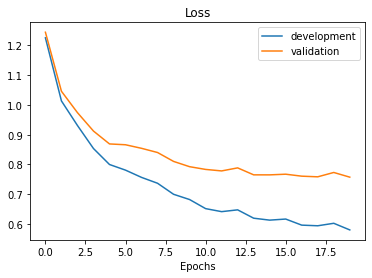

Development (acc, f1):  (0.825015200648561, 0.24968658437446262)
Validation (acc, f1):  (0.7870060790273556, 0.212994071826932)


In [ ]:
#@title
#optimizer: SGD #no loss_weights
config6 = {
    "embedding_size": 32,
    "max_pool_size": (2, 2),
    "kernel_size": (3, 3),
    "out_channels": 16,
    "stride": (2, 2),
    "padding": (1, 1),
    "dropout": 0.2,
    "lr": 0.001,
    "num_epochs": 20,
    "cov2_kernel_size": (5, 5),
    "batch_size": 8}
model6 = train_config(config6, devset, valset)
print("Development (acc, f1): ", evaluate_model(config6, model6, devset))
print("Validation (acc, f1): ", evaluate_model(config6, model6, valset))

Epoch 1/15, avg. loss: 0.8523, lr: 0.0010003234075861476
Epoch 2/15, avg. loss: 0.8457, lr: 0.0010003234075861476
Epoch 3/15, avg. loss: 0.6605, lr: 0.0010003234075861476
Epoch 4/15, avg. loss: 0.5420, lr: 0.0010003234075861476
Epoch 5/15, avg. loss: 0.6144, lr: 0.0010003234075861476
Epoch 6/15, avg. loss: 0.5654, lr: 0.0010003234075861476
Epoch 7/15, avg. loss: 0.4158, lr: 0.0010003234075861476
Epoch 8/15, avg. loss: 0.4627, lr: 0.0010003234075861476
Epoch 9/15, avg. loss: 0.4092, lr: 0.0010003234075861476
Epoch 10/15, avg. loss: 0.4197, lr: 0.0010003234075861476
Epoch 11/15, avg. loss: 0.3575, lr: 0.0005001617037930738
Epoch 12/15, avg. loss: 0.4357, lr: 0.0005001617037930738
Epoch 13/15, avg. loss: 0.2626, lr: 0.0005001617037930738
Epoch 14/15, avg. loss: 0.2951, lr: 0.0005001617037930738
Epoch 15/15, avg. loss: 0.2666, lr: 0.0005001617037930738


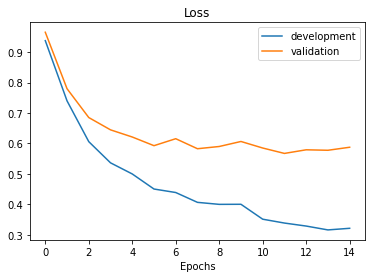

Development (acc, f1):  (0.8991281427412814, 0.7533127395950892)
Validation (acc, f1):  (0.8429136253041363, 0.3479185775971065)


In [ ]:
#@title: model 6
#optimizer: Adam #loss_weights: no #best.params from RayTune
config7 = {
    "embedding_size": 128,
    "max_pool_size": (6, 12),
    "kernel_size": (3, 3),
    "out_channels": 16,
    "stride": (2, 1),
    "padding": (1, 0),
    "dropout": 0.1,
    "lr": 0.0010003234075861476,
    "num_epochs": 15,
    "cov2_kernel_size": (3, 3),
    "batch_size":32}
model7 = train_config(config7, devset, valset)
print("Development (acc, f1): ", evaluate_model(config7,model7, devset))
print("Validation (acc, f1): ", evaluate_model(config7,model7, valset))

Epoch 1/15, avg. loss: 1.1805, lr: 0.0010003234075861476
Epoch 2/15, avg. loss: 1.2234, lr: 0.0010003234075861476
Epoch 3/15, avg. loss: 0.8740, lr: 0.0010003234075861476
Epoch 4/15, avg. loss: 1.0518, lr: 0.0010003234075861476
Epoch 5/15, avg. loss: 0.8369, lr: 0.0010003234075861476
Epoch 6/15, avg. loss: 0.8972, lr: 0.0010003234075861476
Epoch 7/15, avg. loss: 0.8282, lr: 0.0010003234075861476
Epoch 8/15, avg. loss: 0.8034, lr: 0.0010003234075861476
Epoch 9/15, avg. loss: 0.7657, lr: 0.0010003234075861476
Epoch 10/15, avg. loss: 0.7515, lr: 0.0010003234075861476
Epoch 11/15, avg. loss: 0.7218, lr: 0.0005001617037930738
Epoch 12/15, avg. loss: 0.6738, lr: 0.0005001617037930738
Epoch 13/15, avg. loss: 0.6525, lr: 0.0005001617037930738
Epoch 14/15, avg. loss: 0.7943, lr: 0.0005001617037930738
Epoch 15/15, avg. loss: 0.7350, lr: 0.0005001617037930738


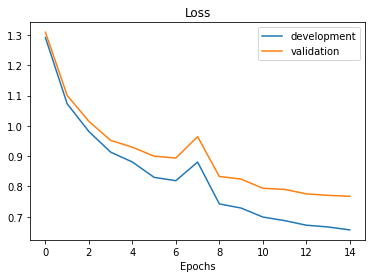

Development (acc, f1):  (0.8004359286293593, 0.22909683068523773)
Validation (acc, f1):  (0.7750912408759124, 0.2035968928236158)


In [ ]:
#@title
#optimizer: SGD #other params: from confiq7
config8 = {
    "embedding_size": 128,
    "max_pool_size": (6, 12),
    "kernel_size": (3, 3),
    "out_channels": 16,
    "stride": (2, 1),
    "padding": (1, 0),
    "dropout": 0.1,
    "lr": 0.0010003234075861476,
    "num_epochs": 15,
    "cov2_kernel_size": (3, 3),
    "batch_size":32}
model8 = train_config(config8, devset, valset)
print("Development (acc, f1): ", evaluate_model(config8,model8, devset))
print("Validation (acc, f1): ", evaluate_model(config8,model8, valset))

## Performance on the Test set
``Model7 gives the best performance on Validation data.. now we use it to predict data on test set and observe how well the model performs.``

In [ ]:
model7

LanguageIdentification(
  (embeddings): Embedding(5703, 128)
  (conv2d): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 1), padding=(1, 0))
  (max_pool2d): MaxPool2d(kernel_size=(6, 12), stride=(2, 1), padding=(1, 0), dilation=1, ceil_mode=False)
  (conv2d_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 1), padding=(1, 0))
  (max_pool2d_2): MaxPool2d(kernel_size=(6, 12), stride=(2, 1), padding=(1, 0), dilation=1, ceil_mode=False)
  (linear): Linear(in_features=3264, out_features=70, bias=True)
)

In [ ]:
encoded_test_set,_ = encode_dataset(df_test, max_len=max_len)
testset = TweetDataset(encoded_test_set)
print("Test (acc, f1): ", evaluate_model(config7, model7, testset))

Test (acc, f1):  (0.8398248792270532, 0.3112823958726291)
